### Carbon and water fluxes partitioning using <span style="border: 1px solid #FF0000; padding: 2px; background-color: #FFFFFF; color: #FF0000;">Conditional Eddy Covariance (CEC)</span>  method, <span style="border: 1px solid #FF0000; padding: 2px; background-color: #FFFFFF; color: #FF0000;">Modified Relaxed Eddy <br><br>Accumulation (MREA)</span>  method, and <span style="border: 1px solid #FF0000; padding: 2px; background-color: #FFFFFF; color: #FF0000;">Flux Variance Similarity (FVS) theory-based</span> method. 
## References: 
1. Zahn, E., Bou-Zeid, E., Good, S.P., Katul, G.G., Thomas, C.K., Ghannam, K., Smith, J.A., Chamecki, M., Dias, N.L., Fuentes, J.D. and Alfieri, J.G., 2022. Direct partitioning of eddy-covariance water and carbon dioxide fluxes into ground and plant components. Agricultural and Forest Meteorology, 315, p.108790. https://doi.org/10.1016/j.agrformet.2021.108790

2. Thomas, C. et al., 2008. Estimating daytime subcanopy respiration from conditional sampling methods applied to multi-scalar high frequency turbulence time series. agricultural and forest meteorology, 148(8-9): 1210-1229. https://doi.org/10.1016/j.agrformet.2008.03.002

3. Skaggs, T., Anderson, R., Alfieri, J., Scanlon, T. and Kustas, W., 2018. Fluxpart: Open source software for partitioning carbon dioxide and water vapor fluxes. Agricultural and Forest Meteorology, 253: 218-224. https://doi.org/10.1016/j.agrformet.2018.02.019

4. Raghav, Pushpendra, Pradeep Wagle, Mukesh Kumar, Tirtha Banerjee, and James PS Neel. "Vegetation Index‐Based Partitioning of Evapotranspiration Is Deficient in Grazed Systems." Water Resources Research 58, no. 8 (2022): e2022WR032067. https://doi.org/10.1029/2022WR032067


<span style="border: 1px solid #FF1111; padding: 2px; background-color: #FFFFFF; color: #FF1111;">Written by: [Pushpendra Raghav](https://praghav444.github.io/), The University of Alabama</span> 

Email: ppushpendra@crimson.ua.edu 

## CEC
- CEC method for flux partitioning is based on <span style="border: 1px solid #FF0000; padding: 2px; background-color: #FFFFFF; color: #FF0000;">quadrant analysis</span>  and <span style="border: 1px solid #FF0000; padding: 2px; background-color: #FFFFFF; color: #FF0000;">conditional sampling</span> 

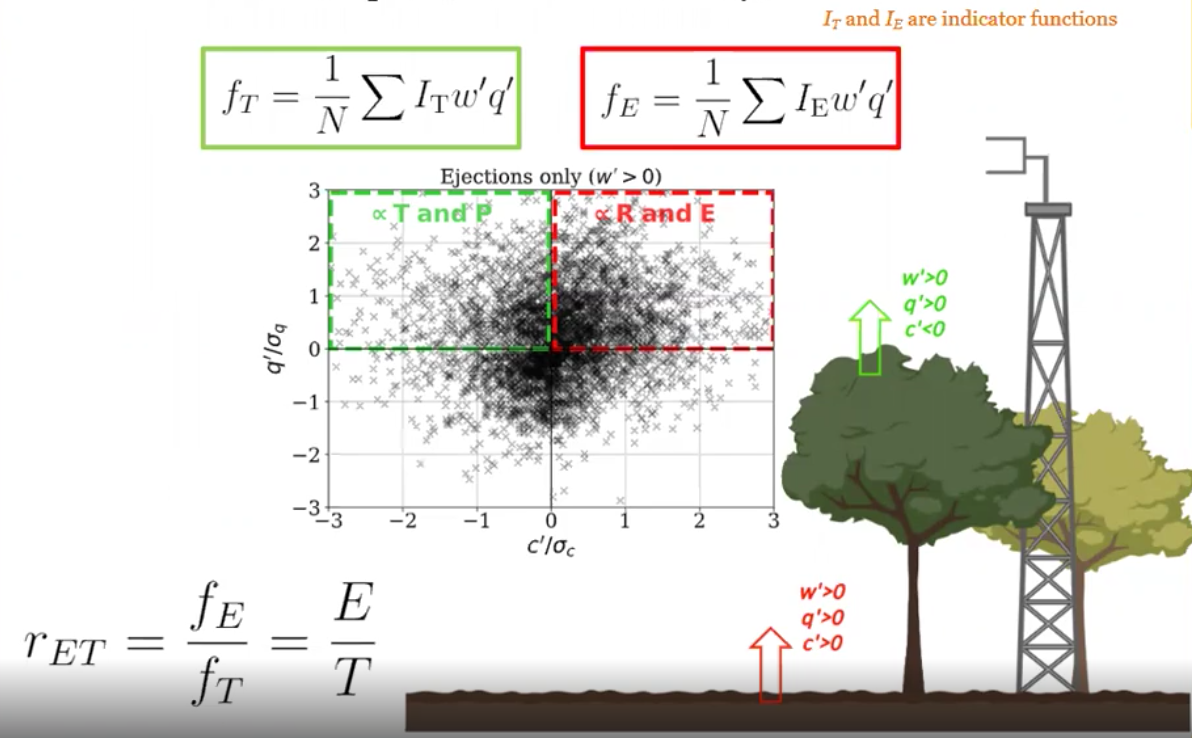

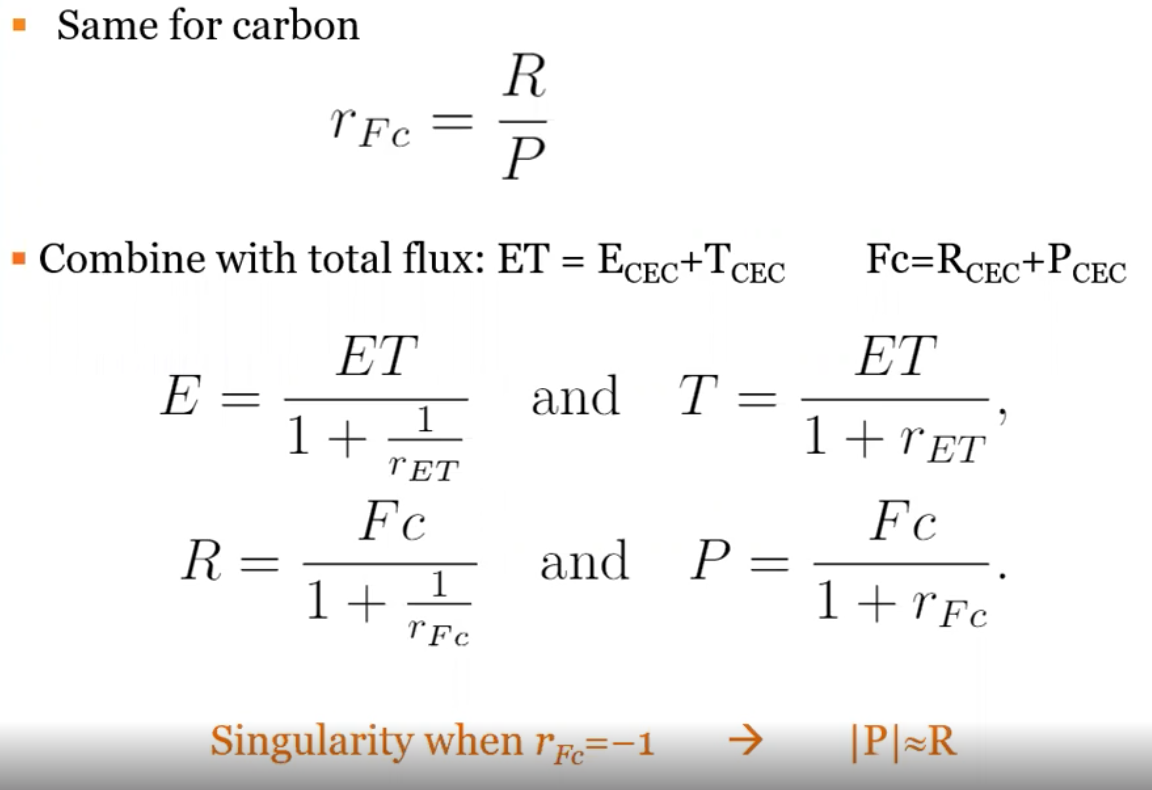

Images credit: Einara Zahn, Princeton University, Princeton, NJ, United States

[Einara et al., 2021](https://doi.org/10.1016/j.agrformet.2021.108790)




## MREA
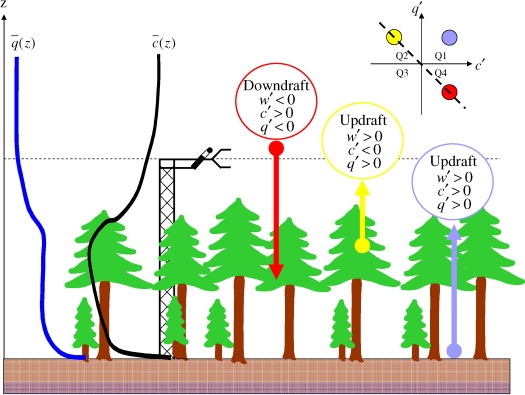
The MREA method assumes the similarity of turbulent transport of non-stomatal fluxes (respiration and evaporation) from the soil ([Thomas et al., 2008](https://doi.org/10.1016/j.agrformet.2008.03.002)). Respiration and E are computed using statistics from EC measurements first. Stomatal fluxes (photosynthesis and T) are computed as the residuals from the total CO2 fluxes and ET. To avoid, negative T and overestimation of respiration during periods of negligible photosynthesis, solutions for both CO2 fluxes and ET are considered biophysically meaningful if E derived from MREA is less than ET (EMREA < ET). Four quadrants are constructed as Q1 for c′ > 0 and q′ > 0, Q2 for c′ < 0 and q′ > 0, Q3 for c′ < 0 and q′ < 0, and Q4 for c′ > 0 and q′ < 0. Details on the derivation of the MREA method are available from the past study ([Thomas et al., 2008](https://doi.org/10.1016/j.agrformet.2008.03.002)).  

## FVS
![](CO2_H2O_annimation.gif)

The FVS method can simultaneously partition evapotranspiration (ET) and net ecosystem CO2 exchange (NEE) into their primary components, that is, T and E for ET, and photosynthesis (P) and respiration (R) for NEE, based on the correlation between high-frequency EC measurements of carbon dioxide and water vapor fluxes along with measured or estimated leaf-scale water use efficiency (WUE). 

[Scanlon et al., 2008](https://doi.org/10.1029/2008WR006932)

## Required Modules

In [1]:
from glob import glob
import os
from os.path import basename
import zipfile
import pandas as pd
import numpy as np
from math import exp
import csv
from scipy import signal
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings('ignore')

## Some Important Functions

In [2]:
#------------------------------------------------------
# Physical constants
class Constants:
    """
    Define constants
    """
    epsilon = 0.622 # ratio of the molecular weight of water vapor to dry air
    UNIVERSAL_GAS = 8.3144598  # J/K/mol
    MOLECULAR_WEIGHT = {'dryair':0.0289645, 'vapor':0.018016, 'co2':0.044010}
    SPECIFIC_GAS_CONSTANT = {'dryair':UNIVERSAL_GAS / MOLECULAR_WEIGHT['dryair'],
                             'vapor':UNIVERSAL_GAS / MOLECULAR_WEIGHT['vapor'],
                             'co2':UNIVERSAL_GAS / MOLECULAR_WEIGHT['co2']}
    Rgas_vapor = SPECIFIC_GAS_CONSTANT['vapor']  # J kg-1 K-1
    Rd = 287                      # gas constant of dry air - J/K/kg
    Lv = 2.453*10**6              # latent heat - J/kg
    rho_w = 1000                  # density of water - kg/m3
    VON_KARMAN=0.4                # von Karman constant
    diff_ratio=1.6                # Ratio of diffusivities water/co2
    g=9.8160                      # gravity m/s2
    SPECIFIC_HEAT_CAPACITY = {'dryair':1004.67}   # J/K/kg
#------------------------------------------------------

#------------------------------------------------------
# Some Important functions
#------------------------------------------------------
def sat_vapor_press(t_kelvin):
    ''' Calculates saturation vapour pressure
    
        Parameters
        ----------
        t_kelvin: float
                  Air temperature (K)
        
        Returns
        -------
        es: float
            Saturation vapour pressure (Pa)
    '''
    tr = 1 - 373.15 / t_kelvin
    arg = 13.3185 * tr - 1.9760 * tr ** 2 - 0.6445 * tr ** 3 - 0.1299 * tr ** 4
    es = 101325.0 * np.exp(arg)
    return es

def vapor_press_deficit(rho_vapor, t_kelvin):
    ''' Calculates vapour pressure defict
    
        Parameters
        ----------
        rho_vapor: float
                   water vapour concentration (kg m-3)
        t_kelvin: float
                  Air temperature (K)
                  
        Returns
        -------
        VPD: float
             Vapour pressure deficit (Pa)
    '''
    vpd = sat_vapor_press(t_kelvin) - rho_vapor * Rgas_vapor * t_kelvin
    return vpd

def specific_humidity(rho_vapor, t_kelvin, air_press):
    ''' Calculates Specific Humidity
    
        Parameters
        ----------
        rho_vapor: float
                   water vapour concentration (kg m-3)   # rho_vapor (kg m-3) = rho_vapor (mmol m-3) * 1e-3*MOLECULAR_WEIGHT['vapor']
        t_kelvin: float
                  Air temperature (K)
        air_pressure: float
                      Air pressure (Pa)
                  
        Returns
        -------
        q: float
             Specific Humidity (kg kg-1)
    '''
    ea = rho_vapor * Rgas_vapor * t_kelvin  # Actual vapour pressure (Pa)
    q = epsilon*ea/(air_press - (1 - epsilon)*ea)
    return q

def qflux_mass_to_heat(massflux, t_kelvin):
    ''' Calculates Specific Humidity
    
        Parameters
        ----------
        massflux: float
                   water vapour flux (kg m-2 s-1)   # Fq = cov(q, w)
        t_kelvin: float
                  Air temperature (K)
                  
        Returns
        -------
        LE: float
             Latent Heat Flux (W m-2)
    '''
    Lv = 2.5008e6 - 2366.8 * (t_kelvin - 273.15)  # J/kg
    LE = massflux * Lv
    return LE

def _rolling_window(x, window_length, func1d, step=1, return_rolled=False):
    # Adopted from https://github.com/agile-geoscience/welly/blob/master/welly/curve.py
    """
    Smoother for other smoothing/conditioning functions.
    Args:
        window_length (int): the window length.
        func1d (function): a function that takes a 1D array and returns a
            scalar.
        step (int): if you want to skip samples in the shifted versions.
            Don't use this for smoothing, you will get strange results.
    Returns:
        ndarray: the resulting array.
    """
    # Force odd.
    if window_length % 2 == 0:
        window_length += 1

    shape = x.shape[:-1] + (x.shape[-1], window_length)
    strides = x.strides + (step*x.strides[-1],)
    data = np.nan_to_num(x)
    data = np.pad(data, int(step*window_length//2), mode='edge')
    rolled = np.lib.stride_tricks.as_strided(data,
                                             shape=shape,
                                             strides=strides)
    result = np.apply_along_axis(func1d, -1, rolled)
    result[np.isnan(x)] = np.nan

    if return_rolled:
        return result, rolled
    else:
        return result

def despike(x, window_length=33, z=2):
    # Adopted from https://github.com/agile-geoscience/welly/blob/master/welly/curve.py
    """
    Args:
        window (int): window length in samples
        z (float): Z score
    Returns:
        Curve.
    """
    z *= np.nanstd(x)  # Transform to curve's units
    curve_sm = _rolling_window(x, window_length, np.median)
    spikes = np.where(np.nan_to_num(x - curve_sm) > z)[0]
    spukes = np.where(np.nan_to_num(curve_sm - x) > z)[0]
    out = np.copy(x)
    out[spikes] = curve_sm[spikes] + z
    out[spukes] = curve_sm[spukes] - z
    return out

def virtual_temperature(Ta, h2o, Pa):
    # Calculates virtual temperature [K] from air temperature, water concentration, and air pressure
    """
    Args:
        Ta: Air temperature [K]
        h2o: water vapor concentration [kg m-3]
        Pa: Air pressure [Pa]
    Returns:
        Tv: Virtual temperature [K]
    """
    e = h2o * Constants.SPECIFIC_GAS_CONSTANT['vapor'] * Ta  # vapor pressure [Pa]
    rv = 0.622*e/(Pa - e)   # Mixing ratio
    Tv = Ta*(1+rv/Constants.epsilon)/(1 + rv)
    return Tv

def vapor_pressure_deficit(h2o, Ta):
    # Calculates vapor pressure deficit (kPa) from water vapor concentration and air temperature
    """
    Args:
        Ta: Air temperature [K]
        h2o: water vapor concentration [kg m-3]
    Returns:
        vpd: Vapor pressure deficit [kPa]
    """
    tr = 1 - 373.15 / Ta
    arg = 13.3185 * tr - 1.9760 * tr ** 2 - 0.6445 * tr ** 3 - 0.1299 * tr ** 4
    es = 101325.0 * np.exp(arg) # Saturation vapor pressure (Pa)
    vpd = es - h2o * Constants.SPECIFIC_GAS_CONSTANT['vapor'] * Ta # Pa
    return vpd*1e-3
 

### Input files (Here I am going to demonstrate using only six input files (all .ghg files; format can be different though) having high frequency (10 Hz) data from EC towers.

In [3]:
# Listing all the .ghg files in all the subfolders
datapath = os.path.join("Input_Data/*/*.ghg")
files = sorted(glob(datapath), key=os.path.getmtime)
print(files[0])

Input_Data/temp/2021-08-16T130000_EOMF_IRGA_1.ghg


In [4]:
# Renaming .ghg to .zip
for file in files:
    oldbase = os.path.splitext(file)
    newname = file.replace('.ghg', '.zip')
    output = os.rename(file, newname)

In [5]:
# Deleting unnecessary files
datapath = os.path.join("Input_Data/*/*.metadata")
files = sorted(glob(datapath), key=os.path.getmtime)
for file in files:
    os.remove(file)
datapath = os.path.join("Input_Data/*/*.data")
files = sorted(glob(datapath), key=os.path.getmtime)
for file in files:
    os.remove(file) 

In [6]:
'''
Now only zip files remain in subfolders
'''
# Unzipping zip files and keep the unzipped data to a designated folder (later we can move / organize the files from there 
# without disturbing the original data)
datapath = os.path.join("Input_Data/*/*.zip")
files = sorted(glob(datapath), key=os.path.getmtime)
for file in files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall("Input_Data/")

In [7]:
# Deleting unnecessary files (.metadata files)
datapath = os.path.join("Input_Data/*.metadata")
files = sorted(glob(datapath), key=os.path.getmtime)
for file in files:
    os.remove(file)  
    
datapath = os.path.join("Input_Data/*biomet.data")
files = sorted(glob(datapath), key=os.path.getmtime)
for file in files:
    os.remove(file) 
    
datapath = os.path.join("Input_Data/*.status")
files = sorted(glob(datapath), key=os.path.getmtime)
for file in files:
    os.remove(file) 


Each (.data) file contains high frequency (10 Hz) measurements of carbon and water concentrations and other ancillary data over a 30 minutes time window

In [8]:
# Listing the all .data files
datapath = os.path.join("Input_Data/*.data")
files = sorted(glob(datapath), key=os.path.getmtime)

In [9]:
files

['Input_Data/2021-08-16T130000_EOMF_IRGA_1.data',
 'Input_Data/2021-08-16T133000_EOMF_IRGA_1.data',
 'Input_Data/2021-08-16T140000_EOMF_IRGA_1.data',
 'Input_Data/2021-08-16T143000_EOMF_IRGA_1.data',
 'Input_Data/2021-08-16T150000_EOMF_IRGA_1.data',
 'Input_Data/2021-08-16T153000_EOMF_IRGA_1.data']

In [10]:
i=0  # file 0
# reading the file data
data = pd.read_csv(files[i],skiprows= 7,sep ="\t")  # skiprows=7 Please change here as per your data type/format (Check metadata file or convert .data to .txt for all these information)
# Idea is that we need to remove some intial lines that have some basic info about the data (Include the line with column names)

In [11]:
data.columns

Index(['DATAH', 'Seconds', 'Nanoseconds', 'Sequence Number',
       'Diagnostic Value', 'Diagnostic Value 2', 'Date', 'Time',
       'CO2 Absorptance', 'H2O Absorptance', 'CO2 (mmol/m^3)',
       'H2O (mmol/m^3)', 'Temperature (C)', 'Pressure (kPa)',
       'Aux 1 - U (m/s)', 'Aux 2 - V (m/s)', 'Aux 3 - W (m/s)',
       'Aux 4 - SOS (m/s)', 'Cooler Voltage (V)', 'CO2 (umol/mol)',
       'H2O (mmol/mol)', 'Dew Point (C)', 'H2O Sample', 'H2O Reference',
       'CO2 Sample', 'CO2 Reference', 'CH4 (umol/mol)', 'CH4 (mmol/m^3)',
       'CH4 Temperature', 'CH4 Pressure', 'CH4 Signal Strength',
       'CH4 Auxiliary Input 1', 'CH4 Auxiliary Input 2',
       'CH4 Auxiliary Input 3', 'CH4 Auxiliary Input 4',
       'CH4 Thermocouple Input 1', 'CH4 Thermocouple Input 2',
       'CH4 Thermocouple Input 3', 'CH4 Diagnostic Value', 'CH4 Drop Rate (%)',
       'CHK'],
      dtype='object')

# <u> Important functions for Data Preprocessing </u>

In [12]:
class quality_control(object):
    ''' Performing data pre-processing to retain high quality raw data 
    
        Inputs
        ----------
        data: pandas DataFrame containing variables of interest
        
        index: DateTime
        co2: carbon diooxide density [mg m-3]
        h2o: water vapor density [g m-3]
        u: wind velocity in the x-direction [m s-1]
        v: wind velocity in the y-direction [m s-1]
        w: wind velocity in the z-direction [m s-1]
        Ta: air temperature [degC]
        Pa: air pressure [kPa]
        c_signal_strength: co2 measurement signal strength [optional]
        q_signal_strength: h2o measurement signal strength [optional]
        anem_flag: diagnostic flag of the sonic anemometer [optional]
    '''
    def __init__(self, data):
        self.data = data               # pandas dataframe containing data
    
    def data_preprocess(self):
        
        # 1. Filter outliers and bad quality data
        self.data[(self.data < -2000) | (self.data > 2000)] = np.nan  # Unrealistic data values
        self.data['q'][(self.data['q']<0)] = np.nan  # negative q concentrations
        self.data['c'][(self.data['c']<0)] = np.nan  # negative c concentrations
        if set(['c_signal_strength']).issubset(self.data.columns):
            self.data['c'][self.data['c_signal_strength']<70] = np.nan
            self.data['q'][self.data['c_signal_strength']<70] = np.nan
        if set(['q_signal_strength']).issubset(self.data.columns):
            self.data['c'][self.data['q_signal_strength']<70] = np.nan
            self.data['q'][self.data['q_signal_strength']<70] = np.nan
        if set(['anem_flag']).issubset(self.data.columns):
            self.data['u'][self.data['anem_flag']!=0] = np.nan
            self.data['v'][self.data['anem_flag']!=0] = np.nan
            self.data['w'][self.data['anem_flag']!=0] = np.nan
            
        # 2. Despiking
        self.despike()
        
        # 3. Count the nan percentage
        nan_percentage = pd.Series(self.data.isnull().sum()*100/len(self.data), index=self.data.columns)
        if (nan_percentage['c'] > 10) | (nan_percentage['q'] > 10) | (nan_percentage['w'] > 10) | (nan_percentage['Ta'] > 10):
            self.data['valid'] = False # If more than 10% data is missing then discard that period
            
        # 4. Fill NaNs
        self.data = replace_nans(self.data)
        
        # 5. 2D rotation on wind velocity components
        self.rotate2D()
        
        # 6. Adjusts q and c data series to correct for external effects
        [self.data['q'], self.data['c']] = correct_external(self.data['c']*1e-6, self.data['q']*1e-3, self.data['Ta']+273.15, self.data['Pa']*1e3)
        
    def despike(self, chunk_size='2min',
                detrend={'how':'linear'},
                max_consec_spikes=4,
                cut_func = lambda x: (abs(x - x.median()) > 7*(x - x.median()).abs().median()/0.6745),
                replace_with='interpolation',
                max_percent=1.):
            """
            Applies spikes-check according to Vickers and Mahrt (1997)
            Parameters
            ----------
            self.data: pandas.dataframe
                data to de-spike
            chunk_size: str, int
                size of chunks to consider. If str should be pandas offset string. If int, number of lines.
            detrend: bool
                whether to detrend the data and work  with the fluctuations or to work with the absolute series.
            detrend_kw: dict
                dict of keywords to pass to pymicra.trend in order to detrend data (if detrend==True).
            max_consec_spikes: int
                maximum number of consecutive spikes to actually be considered spikes and substituted
            cut_func: function
                function used to define spikes
            replace_with: str
                method to use when replacing spikes. [Linear interpolation]
            max_percent: float
                maximum percentage of spikes to allow.
            """
            import pandas as pd
            
            original = self.data.copy()
            dfs = splitData(original, rule=chunk_size)
            
            max_count = int(len(original)*max_percent/100.)
            fault_count = pd.Series(len(original), index=original.columns)
            
            for i in range(len(dfs)):
                chunk=dfs[i].copy()

                #-------------------------------
                # This substitutes the spikes to NaNs so it can be replaced later
                if len(chunk)>max_consec_spikes:
                    chunk=limitedSubs(chunk, max_interp=max_consec_spikes, func=cut_func)
                fault_count = fault_count - chunk.count()
                #-------------------------------
        
                #-------------------------------
                # Substitution of spikes happens here
                #trend = pmdata.trend(chunk, how='linear')
                #chunk = chunk.fillna(trend)
                #chunk = replace_nans(chunk)  # Uncomment here if want to replace spikes using interpolation
                #-------------------------------
        
                #-------------------------------
                # We change the chunk in the original list of dfs to concatenate later
                dfs[i]=chunk.copy()
                #-------------------------------

            #---------------------
            # Now we put the chunks back together and maybe correct the trend
            despiked = pd.concat(dfs)
            
            valid = fault_count < max_count
            
            self.data = despiked
            self.data['valid'] = valid
            self.data['fault_count'] = fault_count
    
    def rotate2D(self):
        '''
        Rotates the coordinates of wind data (adopted from 
        https://github.com/tomchor/pymicra/blob/master/pymicra/signal/pysignal.py)
        Ref: Zahn, E., Chor, T. L., and Dias, N. L. (2016). A simple methodology for quality 
        control of micrometeorological datasets. American Journal of Environmental Engineering, 6(4A):135–142.
        '''
        from math import atan2, sqrt
        import numpy as np
        wind_vars = ['u', 'v', 'w']
        
        #-------
        # Definition of the coefficients used to created the rotation matrix
        wind_vec = self.data[wind_vars].mean().values
        m_u, m_v, m_w = wind_vec
        alpha = atan2(m_v,m_u)
        beta =-atan2(m_w, sqrt((m_u**2.)+(m_v**2.)))
        #-------
        #-------
        # Definition of rotation matrix
        DC= np.zeros((3,3))
        DC[0,0],DC[0,1],DC[0,2] = np.cos(alpha)*np.cos(beta), np.cos(beta)*np.sin(alpha),-np.sin(beta)
        DC[1,0],DC[1,1],DC[1,2] =-np.sin(alpha)          , np.cos(alpha)          , 0.
        DC[2,0],DC[2,1],DC[2,2] = np.cos(alpha)*np.sin(beta), np.sin(alpha)*np.sin(beta), np.cos(beta)
        #-------
    
        #-------
        # Application of rotation as a matrix product
        self.data[wind_vars] = np.dot(DC, self.data[wind_vars].values.T).T
        #-------
def replace_nans(dframe):
    return dframe.interpolate(method='index', limit_direction='both')
    
def splitData(data, rule='30min', return_index=False, **kwargs):
    
    """
    Splits a given pandas DataFrame into a series of "rule"-spaced DataFrames
    Parameters
    ----------
    data: pandas dataframe
        data to be split
    rule: str or int 
        If it is a string, it should be a pandas string offset.
            Some possible values (that should be followed by an integer) are:
            D   calendar day frequency
            W   weekly frequency
            M   month end frequency
            MS  month start frequency
            Q   quarter end frequency
            BQ  business quarter endfrequency
            QS  quarter start frequency
            A   year end frequency
            AS  year start frequency
            H   hourly frequency
            T   minutely frequency
            Min minutely frequency
            S   secondly frequency
            L   milliseconds
            U   microseconds
        If it is a int, it should be the number of lines desired in each separated piece.
        If it is None, then the dataframe isn't separated and a list containing only the
        full dataframe is returned.
        
        check it complete at http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
        """
    import pandas as pd
    from itertools import zip_longest as izip

    #---------
    # Choose how to separate the data
    if rule == None:
        out = [ data ]
    elif type(rule) == int:
        out = [ data.iloc[ rule*i : rule*(i+1) ] for i in range(0, len(data)//rule) ]
    else:
        try:
            from itertools import izip_longest as izip
        except ImportError:
            from itertools import zip_longest as izip
        #---------
        # We first create the index in which we base our separation
        # THIS STEP CAN PROBABLY BE IMPROVED
        res_dates = pd.Series(index=data.index).resample(rule, **kwargs).mean().index
        intervals = izip(res_dates, res_dates[1:], fillvalue=data.index[-1] + pd.DateOffset(microseconds=2))
        #---------

        out = [ data.loc[ bdate:edate - pd.DateOffset(microseconds=1) ] for bdate, edate in intervals ]
    #---------

    if return_index:
        return out, res_dates
    else:
        return out

def limitedSubs(data, max_interp=3, func=lambda x: abs(x) > abs(x.std()*4.) ):

    """
    Substitute elements for NaNs if a certain conditions given by fund is met at 
    a maximum of max_interp times in a row.
    If there are more than that number in a row, then they are not substituted.
    Parameters
    -----------
    data: pandas.dataframe
        data to be interpolated
    max_interp: int
        number of maximum NaNs in a row to interpolate
    func: function
        function of x only that determines the which elements become NaNs. Should return
        only True or False.
    Returns
    --------
    df: pandas.dataframe
        dataframe with the elements substituted
    """
    import numpy as np
    from scipy import stats
    df=data.copy()
    cond=func(df)
    for c in df.columns:
        grouper = (cond[c] != cond[c].shift(1)).cumsum() * cond[c]
        fill = df.groupby(grouper)[c].transform(lambda x: x.size) <= max_interp
        #fill = (df.groupby(grouper)[c].transform('size') <= max_interp)
        df.loc[fill & cond[c], c] = np.nan
    return df

def correct_external(co2, h2o, Ta, Pa):
    """Adjusts q and c data series to correct for external effects.
    Water vapor and carbon dioxide series data in the dataframe are
    corrected for external fluctuations associated with air
    temperature and vapor density. 
    References:
    1. E. K. Webb, G. I. Pearman, R. Leuning (1980). Correction of flux measurements for density effects due 
    to head and water vapor transfer. Quart J R Met Soc, 106:85-100.
    2. M. Detto, G. G. Katul (2007). Simplified expression for adjusting higher-order turbulent statistics obtained 
    from open path gas analyzers. Boundary-Layer Meterol, 122:205-216, doi:10.1007/s10546-006-9105-1.

    Args:
        co2: carbon concentration data series [kg m-3]
        Ta: Air temperature [K]
        h2o: water vapor concentration [kg m-3]
        Pa: Air pressure [Pa]
    Returns:
        [co2, h2o]: Corrected time series of co2 [mg m-3] and h2o [g m-3]
    """ 
    co2 = np.array(co2)
    h2o = np.array(h2o)
    Ta = np.array(Ta)
    Pa = np.array(Pa)
    ave_vapor = h2o.mean()
    ave_co2 = co2.mean()
    ave_T = Ta.mean()
    dev_vapor = h2o - ave_vapor
    dev_T = Ta - ave_T

    Pdryair = Pa.mean() - ave_vapor * Constants.SPECIFIC_GAS_CONSTANT['vapor'] * ave_T
    rho_totair = ave_vapor + Pdryair / Constants.SPECIFIC_GAS_CONSTANT['dryair'] / ave_T

    specific_vapor = ave_vapor / rho_totair
    specific_co2 = ave_co2 / rho_totair
    mu = Constants.MOLECULAR_WEIGHT['dryair'] / Constants.MOLECULAR_WEIGHT['vapor']
    muq = mu * specific_vapor
    muc = mu * specific_co2

    h2o += muq * dev_vapor + (1 + muq) * ave_vapor * dev_T / ave_T
    co2 += muc * dev_vapor + (1 + muq) * ave_co2 * dev_T / ave_T
    return  [h2o*1e3, co2*1e6]; 

# Main (Flux Partitioning)
#### Now, we may proceed to read each and every file, do quality control, and perform flux partitioning 

In [13]:
from Partitioning import Partitioning
from pprint import pprint

In [14]:
i=2  # file 2
#-----------------------------------
# Height file (File having the information of canopy and tower measurement height)
ht_file = "Canopy_Tower_Heights/Canopy_Tower_Heights_P13.csv"
# reading the file data
data = pd.read_csv(files[i],skiprows= 7,sep ="\t") # skiprows=7 Please change here as per your data type/format (Check metadata file or convert .data to .txt for all these information)
#Continue... Idea is that we need to remove some intial lines that have some basic info about the data (Include the line with column names)

# some basic operations
data["DateTime"] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format= '%Y-%m-%d %H:%M:%S:%f') # Change as needed
data = data.set_index("DateTime")
data = data.sort_index() # sort data by index
Date = data["Date"][0]
Time = data["Time"][0]
# Keep the columns of our interest only (Change as needed; check columns names in your data and units too)
data = data[['CO2 (mmol/m^3)', 'H2O (mmol/m^3)', 'Aux 1 - U (m/s)', 'Aux 2 - V (m/s)','Aux 3 - W (m/s)',\
             'Temperature (C)', 'Pressure (kPa)']]

# Rename columns
data.columns = ['c','q','u','v','w','Ta','Pa']
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
'''
# Unit Conversion
c --> [mg m-3]  # carbon dioxide density (mg/m3)
q --> [g m-3]   # water vapor density (g/m3)
u --> [m s-1]     # wind velocity in the x direction
v --> [m s-1]     # wind velocity in the y direction
w --> [m s-1]     # wind velocity in the z direction
Ta --> [degC]      # air temperature (degC)
Pa --> [kPa]       # air pressure (kPa)
c_signal_strength --> [%]
'''
data['c'] = data['c']*1e-3*Constants.MOLECULAR_WEIGHT['co2']*1e6  # mmol/m^3 to mg/m^3
data['q'] = data['q']*1e-3*Constants.MOLECULAR_WEIGHT['vapor']*1e3  # mmol/m^3 to g/m^3
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
# Data processing
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
data = quality_control(data)
data.data_preprocess()
data=data.data
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
# Calculate virtual temperature (Tv)
data['Tv'] = virtual_temperature(np.array(data['Ta']+273.15), np.array(data['q']/1000), np.array(data['Pa']*1000))-273.15
# Calculate VPD
data['vpd'] = vapor_pressure_deficit(np.array(data['q']/1000), np.array(data['Ta']+273.15))
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
# Calculate prime quantities by removing linear trend
data['u_p'] = signal.detrend(data['u']) - np.mean(signal.detrend(data['u']))
data['v_p'] = signal.detrend(data['v']) - np.mean(signal.detrend(data['v']))
data['w_p'] = signal.detrend(data['w']) - np.mean(signal.detrend(data['w']))
data['c_p'] = signal.detrend(data['c']) - np.mean(signal.detrend(data['c']))
data['q_p'] = signal.detrend(data['q']) - np.mean(signal.detrend(data['q']))
data['Ta_p'] = signal.detrend(data['Ta']) - np.mean(signal.detrend(data['Ta']))
data['Tv_p'] = signal.detrend(data['Tv']) - np.mean(signal.detrend(data['Tv']))

data['Tvk_p'] = signal.detrend(data['Tv']+273.15) - np.mean(signal.detrend(data['Tv']+273.15))
# Calculate Sensible Heat flux (H; W/m^2)
ave_q = (data['q']*1e-3).mean()
ave_T = (data['Ta']+273.15).mean()
ave_P = (data['Pa']*1000).mean()
Pvap = ave_q * Constants.Rgas_vapor * ave_T
rho_dryair = (ave_P - Pvap) / Constants.SPECIFIC_GAS_CONSTANT['dryair'] / ave_T
rho_totair = rho_dryair + ave_q
Cp = Constants.SPECIFIC_HEAT_CAPACITY['dryair'] * (1 + 0.84 * ave_q / rho_totair)
cov_w_T = sum([data['w_p'][i]*data['Tvk_p'][i] for i in range(len(data['w_p']))])/len(data['w_p'])
H = rho_totair * Cp * cov_w_T
# Calculate correlation between c and q (rho_cq)
rho_qc = np.corrcoef(data['q'], data['c'])
rho_qc = rho_qc[0][1]
# Calculate Mean friction velocity
cov_w_u = sum([data['w_p'][i]*data['u_p'][i] for i in range(len(data['w_p']))])/len(data['w_p'])
cov_w_v = sum([data['w_p'][i]*data['v_p'][i] for i in range(len(data['w_p']))])/len(data['w_p'])
ustar=(cov_w_u ** 2 + cov_w_v ** 2) ** 0.25
#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
# Run MREA, CEC, and FVS with the data processed above
#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
# First rename some of the columns as per Einara's code requirements
data.rename(columns={'c': 'co2', 'q': 'h2o', 'Ta': 'T', 'Pa': 'P', 'Ta_p': 'T_p'}, inplace=True)

# Now---ready to run :)

# Create an object called Partitioning
part = Partitioning(height_file=ht_file, df=data)

# CEC method
part.partCEC(H=0)
print("CEC ")
pprint(part.fluxesCEC)

 # MREA method
part.partREA(H=0.0)
print("MREA ")
pprint(part.fluxesREA)
    
# Compute water-use efficiency
# All models are implemented: 'const_ppm', "const_ratio", "linear", "sqrt", "opt"
part.WaterUseEfficiency(ppath='C4')   # Change here as needed (C3 or C4)
print("WUE ")
pprint(part.wue)

# FVS method - must enter one water-use efficiency in kg_co2/kg_h2o
part.partFVS(W=part.wue['const_ratio'])
print("FVS ")
print(part.fluxesFVS)

CEC 
{'E': 0.0,
 'ET': 129.51472516774385,
 'Fc': -0.5243414193186858,
 'P': -0.5243414193186858,
 'R': 0.0,
 'T': 129.51472516774385,
 'rET': 0.0,
 'rRP': 0.0,
 'status': 'OK'}
MREA 
{'E': 0,
 'ET': 129.52192083001236,
 'Fc': -0.5243705510159662,
 'P': -0.5243705510159662,
 'R': 0,
 'T': 129.52192083001236,
 'status': 'OK'}
WUE 
{'const_ppm': -0.09697985004276746,
 'const_ratio': -0.0822890683762848,
 'linear': -0.014518236395456874,
 'opt': -0.04833805922007014,
 'sqrt': nan}
FVS 
{'ET': 129.52192083001236, 'Fc': -0.5243705510159662, 'E': 75.95044881790412, 'T': 53.57147201210826, 'P': -1.7971245509264655, 'R': 1.272753999910499, 'status': 'OK'}


### Run over multiple files (Can be parallelize to speed up)

In [15]:
final_df_MREA = pd.DataFrame()
final_df_FVS_const_ratio = pd.DataFrame()
final_df_FVS_const_ppm = pd.DataFrame()
final_df_FVS_linear = pd.DataFrame()
final_df_FVS_sqrt = pd.DataFrame()
final_df_FVS_opt = pd.DataFrame()
final_df_CEC = pd.DataFrame()
# Height file
ht_file = "Canopy_Tower_Heights/Canopy_Tower_Heights_P13.csv"
for i in range(len(files)):
    print(i,'/', len(files))
    # reading the file data
    data = pd.read_csv(files[i],skiprows= 7,sep ="\t") # skiprows=7 Please change here as per your data type/format (Check metadata file or convert .data to .txt for all these information)
#Continue... Idea is that we need to remove some intial lines that have some basic info about the data (Include the line with column names)


    
    # some basic operations
    data["DateTime"] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format= '%Y-%m-%d %H:%M:%S:%f') # Change as needed
    data = data.set_index("DateTime")
    data = data.sort_index()  # sort data by index
    Date = data["Date"][0]
    Time = data["Time"][0]
    
    # Keep the columns of our interest only (Change as needed; check columns names in your data and units too)
    data = data[['CO2 (mmol/m^3)', 'H2O (mmol/m^3)', 'Aux 1 - U (m/s)', 'Aux 2 - V (m/s)','Aux 3 - W (m/s)',\
                 'Temperature (C)', 'Pressure (kPa)']]
    
    # Rename columns
    data.columns = ['c','q','u','v','w','Ta','Pa']
    #------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------
    '''
    # Unit Conversion
    c --> [mg m-3]  # carbon dioxide density (mg/m3)
    q --> [g m-3]   # water vapor density (g/m3)
    u --> [m s-1]     # wind velocity in the x direction
    v --> [m s-1]     # wind velocity in the y direction
    w --> [m s-1]     # wind velocity in the z direction
    Ta --> [degC]      # air temperature (degC)
    Pa --> [kPa]       # air pressure (kPa)
    c_signal_strength --> [%]
    '''
    data['c'] = data['c']*1e-3*Constants.MOLECULAR_WEIGHT['co2']*1e6  # mmol/m^3 to mg/m^3
    data['q'] = data['q']*1e-3*Constants.MOLECULAR_WEIGHT['vapor']*1e3  # mmol/m^3 to g/m^3
    
    #------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------
    # Data pre-processing
    #------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------
    data = quality_control(data)
    data.data_preprocess()
    data=data.data
    #------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------
    # Calculate virtual temperature (Tv)
    data['Tv'] = virtual_temperature(np.array(data['Ta']+273.15), np.array(data['q']/1000), np.array(data['Pa']*1000))-273.15
    # Calculate VPD
    data['vpd'] = vapor_pressure_deficit(np.array(data['q']/1000), np.array(data['Ta']+273.15))
    #------------------------------------------------------------------------------------------
    # Check if data is sufficient
    if (np.min(data.count()[0:7]) <= 1000):
        continue
    #------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------
    # Calculate prime quantities by removing linear trend
    data['u_p'] = signal.detrend(data['u']) - np.mean(signal.detrend(data['u']))
    data['v_p'] = signal.detrend(data['v']) - np.mean(signal.detrend(data['v']))
    data['w_p'] = signal.detrend(data['w']) - np.mean(signal.detrend(data['w']))
    data['c_p'] = signal.detrend(data['c']) - np.mean(signal.detrend(data['c']))
    data['q_p'] = signal.detrend(data['q']) - np.mean(signal.detrend(data['q']))
    data['Ta_p'] = signal.detrend(data['Ta']) - np.mean(signal.detrend(data['Ta']))
    data['Tv_p'] = signal.detrend(data['Tv']) - np.mean(signal.detrend(data['Tv']))
                                                                            
    data['Tvk_p'] = signal.detrend(data['Tv']+273.15) - np.mean(signal.detrend(data['Tv']+273.15))
    # Calculate Sensible Heat flux (H; W/m^2)
    ave_q = (data['q']*1e-3).mean()
    ave_T = (data['Ta']+273.15).mean()
    ave_P = (data['Pa']*1000).mean()
    Pvap = ave_q * Constants.Rgas_vapor * ave_T
    rho_dryair = (ave_P - Pvap) / Constants.SPECIFIC_GAS_CONSTANT['dryair'] / ave_T
    rho_totair = rho_dryair + ave_q
    Cp = Constants.SPECIFIC_HEAT_CAPACITY['dryair'] * (1 + 0.84 * ave_q / rho_totair)
    cov_w_T = sum([data['w_p'][i]*data['Tvk_p'][i] for i in range(len(data['w_p']))])/len(data['w_p'])
    H = rho_totair * Cp * cov_w_T
                                                                            
    # Calculate correlation between c and q (rho_cq)
    rho_qc = np.corrcoef(data['q'], data['c'])
    rho_qc = rho_qc[0][1]
    # Calculate Mean friction velocity
    cov_w_u = sum([data['w_p'][i]*data['u_p'][i] for i in range(len(data['w_p']))])/len(data['w_p'])
    cov_w_v = sum([data['w_p'][i]*data['v_p'][i] for i in range(len(data['w_p']))])/len(data['w_p'])
    ustar=(cov_w_u ** 2 + cov_w_v ** 2) ** 0.25
    # Calculate Monin-Obukhuv length (m)
    if H == 0:
        L = np.nan
    else:
        L = -1*rho_totair*Cp*ustar**3*(data['Tv']+273.15).mean()/(0.41*9.81*H)
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    # Run MREA, CEC, and FVS with the data processed above
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    # First rename some of the columns as per Einara's code requirements
    data.rename(columns={'c': 'co2', 'q': 'h2o', 'Ta': 'T', 'Pa': 'P', 'Ta_p': 'T_p'}, inplace=True)
    
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    # Create an object called Partitioning
    part = Partitioning(height_file=ht_file, df=data)
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    # CEC method
    part.partCEC(H=0)
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    # MREA method
    part.partREA(H=0.0)
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------    
    # Compute leaf-scale water-use efficiency
    # All models are implemented: 'const_ppm', "const_ratio", "linear", "sqrt", "opt"
    part.WaterUseEfficiency(ppath='C4') # Change here as needed (C3 or C4)
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    # Save outputs
    mean_df = data.mean()
    df_CEC = pd.DataFrame([[Date,Time,mean_df['co2'],mean_df['h2o'],mean_df['u'], \
                            mean_df['v'], mean_df['w'],mean_df['T'],\
                            mean_df['P'], mean_df['Tv'],mean_df['vpd'], H, rho_qc, ustar, L, \
                            mean_df['valid'],mean_df['fault_count'], \
                            part.fluxesCEC['ET'], part.fluxesCEC['E'], part.fluxesCEC['T'],\
                            part.fluxesCEC['Fc'], part.fluxesCEC['P'], part.fluxesCEC['R'],\
                            part.fluxesCEC['rRP'], part.fluxesCEC['rET'], part.fluxesCEC['status']]], \
                          columns = ['Date','Time','CO2 (mg/m^3)','H2O (g/m^3)','U (m/s)','V (m/s)', 'W (m/s)',\
                                     'Ta (C)','Pa (kPa)','Tv (C)','VPD (kPa)','H (W/m^2)', 'rho_qc', 'ustar (m/s)', 'L_MO (m)',\
                                     'valid','fault_count','LE', 'LEe', 'LEt', 'Fc', 'Fcp', 'Fcr', 'rR_P', 'rE_T', 'status'])
    
    df_MREA = pd.DataFrame([[Date,Time,mean_df['co2'],mean_df['h2o'],mean_df['u'], \
                            mean_df['v'], mean_df['w'],mean_df['T'],\
                            mean_df['P'], mean_df['Tv'],mean_df['vpd'], H, rho_qc, ustar, L, \
                            mean_df['valid'],mean_df['fault_count'], \
                            part.fluxesREA['ET'], part.fluxesREA['E'], part.fluxesREA['T'],\
                            part.fluxesREA['Fc'], part.fluxesREA['P'], part.fluxesREA['R'],\
                            part.fluxesREA['status']]], \
                          columns = ['Date','Time','CO2 (mg/m^3)','H2O (g/m^3)','U (m/s)','V (m/s)', 'W (m/s)',\
                                     'Ta (C)','Pa (kPa)','Tv (C)','VPD (kPa)', 'H (W/m^2)', 'rho_qc', 'ustar (m/s)', 'L_MO (m)','valid',
                                     'fault_count','LE', 'LEe', 'LEt', 'Fc', 'Fcp', 'Fcr','status'])
    


    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    # FVS method - must enter one water-use efficiency in kg_co2/kg_h2o
    part.partFVS(W=part.wue['const_ratio'])
    df_FVS_const_ratio = pd.DataFrame([[Date,Time,mean_df['co2'],mean_df['h2o'],mean_df['u'], \
                            mean_df['v'], mean_df['w'],mean_df['T'],\
                            mean_df['P'], mean_df['Tv'],mean_df['vpd'], H, rho_qc, ustar, L, \
                            mean_df['valid'],mean_df['fault_count'], \
                            part.fluxesFVS['ET'], part.fluxesFVS['E'], part.fluxesFVS['T'],\
                            part.fluxesFVS['Fc'], part.fluxesFVS['P'], part.fluxesFVS['R'],\
                            part.wue['const_ratio'], part.fluxesFVS['status']]], \
                          columns = ['Date','Time','CO2 (mg/m^3)','H2O (g/m^3)','U (m/s)','V (m/s)', 'W (m/s)',\
                                     'Ta (C)','Pa (kPa)','Tv (C)','VPD (kPa)', 'H (W/m^2)', 'rho_qc', 'ustar (m/s)', 'L_MO (m)', 'valid',
                                     'fault_count','LE', 'LEe', 'LEt', 'Fc', 'Fcp', 'Fcr', 'wue','status'])
    part.partFVS(W=part.wue['const_ppm'])
    df_FVS_const_ppm = pd.DataFrame([[Date,Time,mean_df['co2'],mean_df['h2o'],mean_df['u'], \
                            mean_df['v'], mean_df['w'],mean_df['T'],\
                            mean_df['P'], mean_df['Tv'],mean_df['vpd'], H, rho_qc, ustar, L, \
                            mean_df['valid'],mean_df['fault_count'], \
                            part.fluxesFVS['ET'], part.fluxesFVS['E'], part.fluxesFVS['T'],\
                            part.fluxesFVS['Fc'], part.fluxesFVS['P'], part.fluxesFVS['R'],\
                            part.wue['const_ppm'], part.fluxesFVS['status']]], \
                          columns = ['Date','Time','CO2 (mg/m^3)','H2O (g/m^3)','U (m/s)','V (m/s)', 'W (m/s)',\
                                     'Ta (C)','Pa (kPa)','Tv (C)','VPD (kPa)', 'H (W/m^2)', 'rho_qc',  'ustar (m/s)', 'L_MO (m)','valid',
                                     'fault_count','LE', 'LEe', 'LEt', 'Fc', 'Fcp', 'Fcr', 'wue','status'])
    part.partFVS(W=part.wue['linear'])
    df_FVS_linear = pd.DataFrame([[Date,Time,mean_df['co2'],mean_df['h2o'],mean_df['u'], \
                            mean_df['v'], mean_df['w'],mean_df['T'],\
                            mean_df['P'], mean_df['Tv'],mean_df['vpd'], H, rho_qc, ustar, L,\
                            mean_df['valid'],mean_df['fault_count'], \
                            part.fluxesFVS['ET'], part.fluxesFVS['E'], part.fluxesFVS['T'],\
                            part.fluxesFVS['Fc'], part.fluxesFVS['P'], part.fluxesFVS['R'],\
                            part.wue['linear'], part.fluxesFVS['status']]], \
                          columns = ['Date','Time','CO2 (mg/m^3)','H2O (g/m^3)','U (m/s)','V (m/s)', 'W (m/s)',\
                                     'Ta (C)','Pa (kPa)','Tv (C)','VPD (kPa)', 'H (W/m^2)', 'rho_qc', 'ustar (m/s)', 'L_MO (m)', 'valid',
                                     'fault_count','LE', 'LEe', 'LEt', 'Fc', 'Fcp', 'Fcr', 'wue','status'])
    part.partFVS(W=part.wue['sqrt'])
    df_FVS_sqrt = pd.DataFrame([[Date,Time,mean_df['co2'],mean_df['h2o'],mean_df['u'], \
                            mean_df['v'], mean_df['w'],mean_df['T'],\
                            mean_df['P'], mean_df['Tv'],mean_df['vpd'], H, rho_qc, ustar, L,\
                            mean_df['valid'],mean_df['fault_count'], \
                            part.fluxesFVS['ET'], part.fluxesFVS['E'], part.fluxesFVS['T'],\
                            part.fluxesFVS['Fc'], part.fluxesFVS['P'], part.fluxesFVS['R'],\
                            part.wue['sqrt'], part.fluxesFVS['status']]], \
                          columns = ['Date','Time','CO2 (mg/m^3)','H2O (g/m^3)','U (m/s)','V (m/s)', 'W (m/s)',\
                                     'Ta (C)','Pa (kPa)','Tv (C)','VPD (kPa)','H (W/m^2)', 'rho_qc', 'ustar (m/s)', 'L_MO (m)', 'valid',
                                     'fault_count','LE', 'LEe', 'LEt', 'Fc', 'Fcp', 'Fcr', 'wue','status'])
    part.partFVS(W=part.wue['opt'])
    df_FVS_opt = pd.DataFrame([[Date,Time,mean_df['co2'],mean_df['h2o'],mean_df['u'], \
                            mean_df['v'], mean_df['w'],mean_df['T'],\
                            mean_df['P'], mean_df['Tv'],mean_df['vpd'], H, rho_qc, ustar, L,\
                            mean_df['valid'],mean_df['fault_count'], \
                            part.fluxesFVS['ET'], part.fluxesFVS['E'], part.fluxesFVS['T'],\
                            part.fluxesFVS['Fc'], part.fluxesFVS['P'], part.fluxesFVS['R'],\
                            part.wue['opt'], part.fluxesFVS['status']]], \
                          columns = ['Date','Time','CO2 (mg/m^3)','H2O (g/m^3)','U (m/s)','V (m/s)', 'W (m/s)',\
                                     'Ta (C)','Pa (kPa)','Tv (C)','VPD (kPa)', 'H (W/m^2)', 'rho_qc', 'ustar (m/s)', 'L_MO (m)', 'valid',
                                     'fault_count','LE', 'LEe', 'LEt', 'Fc', 'Fcp', 'Fcr', 'wue','status'])
    #------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------
    final_df_CEC = final_df_CEC.append(df_CEC)
    final_df_MREA = final_df_MREA.append(df_MREA)
    final_df_FVS_const_ratio = final_df_FVS_const_ratio.append(df_FVS_const_ratio)
    final_df_FVS_const_ppm = final_df_FVS_const_ppm.append(df_FVS_const_ppm)
    final_df_FVS_linear = final_df_FVS_linear.append(df_FVS_linear)
    final_df_FVS_sqrt = final_df_FVS_sqrt.append(df_FVS_sqrt)
    final_df_FVS_opt = final_df_FVS_opt.append(df_FVS_opt)
#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
final_df_CEC.to_csv('Output/C4_demo/Results_CEC_P13.csv', index=False)
final_df_MREA.to_csv('Output/C4_demo/Results_MREA_P13.csv', index=False)
final_df_FVS_const_ratio.to_csv('Output/C4_demo/Results_FVS_const_ratio_P13.csv', index=False)
final_df_FVS_const_ppm.to_csv('Output/C4_demo/Results_FVS_const_ppm_P13.csv', index=False)
final_df_FVS_linear.to_csv('Output/C4_demo/Results_FVS_linear_P13.csv', index=False)
final_df_FVS_sqrt.to_csv('Output/C4_demo/Results_FVS_sqrt_P13.csv', index=False)
final_df_FVS_opt.to_csv('Output/C4_demo/Results_FVS_opt_P13.csv', index=False)
#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------

0 / 6
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
